# Data Exploration: GTZAN Music Genre Dataset

This notebook explores the GTZAN dataset for music genre classification.

**Goals:**
- Overview of data structure
- Analysis of audio features
- Visualization of genre distribution
- Initial spectrogram analysis

## 1. Setup and Imports

**Key Setup:**
- We use `librosa` for audio processing and spectrogram generation
- The dataset structure includes both raw audio files (`.wav`) and pre-extracted features (`.csv`)
- Project paths are configured relative to notebook location for portability


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Define paths
PROJECT_ROOT = Path('../').resolve()
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
AUDIO_PATH = DATA_RAW / 'genres_original'
FEATURES_30SEC = DATA_RAW / 'features_30_sec.csv'
FEATURES_3SEC = DATA_RAW / 'features_3_sec.csv'

print(f"Project root: {PROJECT_ROOT}")
print(f"Audio data: {AUDIO_PATH}")
print(f"Audio path exists: {AUDIO_PATH.exists()}")

Project root: /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness
Audio data: /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/data/raw/genres_original
Audio path exists: True


## 2. Dataset Overview

**Dataset Insights:**
- The GTZAN dataset contains 30-second audio clips across 10 music genres
- The CSV provides ready-to-use features (but we'll generate spectograms for CNN training)


In [27]:
# Load the 30-second features CSV
if FEATURES_30SEC.exists():
    df_30sec = pd.read_csv(FEATURES_30SEC)
    print(f"Dataset shape: {df_30sec.shape}")
    print(f"\nFirst few columns: {list(df_30sec.columns[:10])}")
    display(df_30sec.head())
else:
    print(f"File not found: {FEATURES_30SEC}")

Dataset shape: (1000, 60)

First few columns: ['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var']


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


**Genre Distribution:**
- The dataset is balanced with equal samples per genre (100 files each)
- Genres include: blues, classical, country, disco, hip-hop, jazz, metal, pop, reggae, rock


In [28]:
# Explore genres
if AUDIO_PATH.exists():
    genres = sorted([d.name for d in AUDIO_PATH.iterdir() if d.is_dir()])
    print(f"Genres ({len(genres)}): {genres}")
    
    # Count files per genre
    genre_counts = {}
    for genre in genres:
        genre_path = AUDIO_PATH / genre
        audio_files = list(genre_path.glob('*.wav'))
        genre_counts[genre] = len(audio_files)
    
    print(f"\nFiles per genre:")
    for genre, count in genre_counts.items():
        print(f"  {genre}: {count} files")
else:
    print(f"Audio path not found: {AUDIO_PATH}")
    print("Please download the GTZAN dataset from Kaggle")

Genres (10): ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

Files per genre:
  blues: 100 files
  classical: 100 files
  country: 100 files
  disco: 100 files
  hiphop: 100 files
  jazz: 100 files
  metal: 100 files
  pop: 100 files
  reggae: 100 files
  rock: 100 files


## 4. Audio Waveform and Spectrogram Analysis

**Audio Characteristics:**
- **Waveform** shows amplitude variations over time - useful for identifying dynamics and rhythm patterns
- **Mel Spectrogram** represents frequency content over time in a perceptually-relevant scale
- Different genres show distinct patterns:
  - Metal: High energy across frequencies, dense patterns
  - Classical: More varied dynamics, clear harmonic structures
  - Hip-hop: Strong low-frequency content, repetitive patterns
- Mel spectrograms will be our input features for the CNN model


In [29]:
# Load a sample audio file from each genre
def load_sample_audio(genre, sample_idx=0):
    """Load a sample audio file from a specific genre."""
    genre_path = AUDIO_PATH / genre
    audio_files = sorted(genre_path.glob('*.wav'))
    if audio_files:
        audio_path = audio_files[sample_idx]
        y, sr = librosa.load(audio_path, duration=30)
        return y, sr, audio_path.name
    return None, None, None

# Select a sample genre to visualize
sample_genre = 'metal'  # Change this to explore different genres
y, sr, filename = load_sample_audio(sample_genre)

if y is not None:
    print(f"Loaded: {filename}")
    print(f"Sample rate: {sr} Hz")
    print(f"Duration: {len(y)/sr:.2f} seconds")
    print(f"Audio shape: {y.shape}")

Loaded: metal.00000.wav
Sample rate: 22050 Hz
Duration: 30.00 seconds
Audio shape: (661500,)


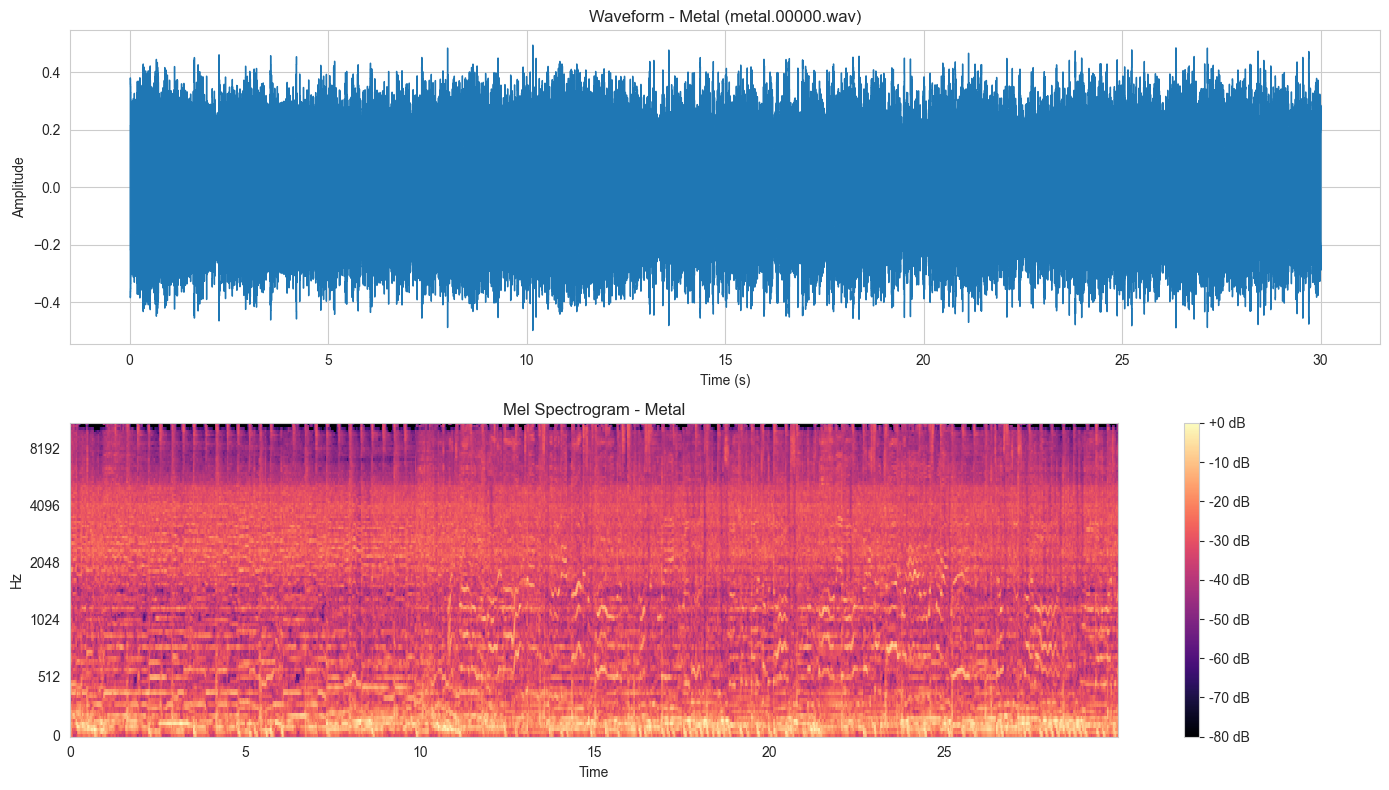

In [30]:
# Visualize waveform
if y is not None:
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Waveform
    librosa.display.waveshow(y, sr=sr, ax=axes[0])
    axes[0].set_title(f'Waveform - {sample_genre.capitalize()} ({filename})')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    
    # Mel Spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_db = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[1])
    axes[1].set_title(f'Mel Spectrogram - {sample_genre.capitalize()}')
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

## 5. Compare Spectrograms Across Genres

**Cross-Genre Observations:**
- **Visual differences** between genres are apparent even to human eye
- These visual patterns suggest CNNs can learn discriminative features
- **For Grad-CAM**: We expect the model to focus on genre-specific frequency regions


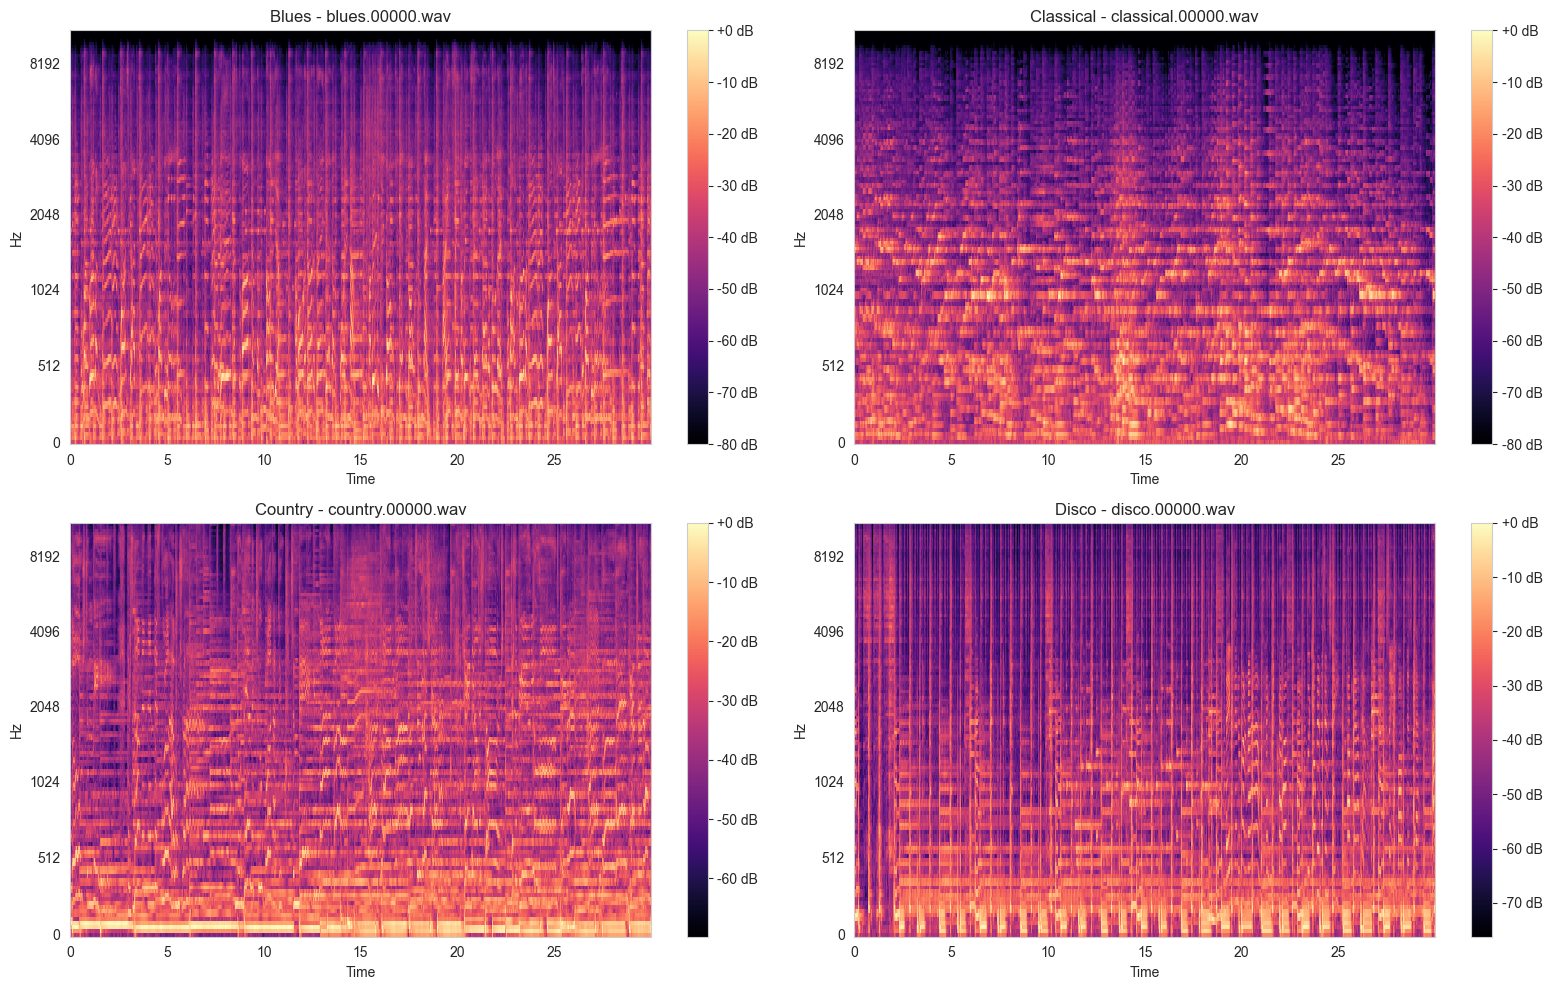

In [31]:
# Compare spectrograms from different genres
if 'genres' in locals() and len(genres) > 0:
    # Select 4 genres to compare
    sample_genres = genres[:4] if len(genres) >= 4 else genres
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, genre in enumerate(sample_genres):
        y, sr, filename = load_sample_audio(genre)
        if y is not None:
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            S_db = librosa.power_to_db(S, ref=np.max)
            img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[idx])
            axes[idx].set_title(f'{genre.capitalize()} - {filename}')
            fig.colorbar(img, ax=axes[idx], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

## 6. Next Steps

Based on this exploration, we can proceed to:
1. **Preprocessing**: Generate spectrograms for all audio files
2. **Model Training**: Build CNN for genre classification
3. **Adversarial Attacks**: Add noise/perturbations to test robustness
4. **Grad-CAM Analysis**: Visualize which spectrogram regions influence predictions